In [ ]:
! pip install diffusers transformers accelerate safetensors omegaconf xformers triton

In [3]:
import torch
from diffusers import AutoencoderKL, DDIMScheduler, UNet2DConditionModel
from transformers import CLIPTextModel, CLIPTokenizer
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm
import random

class RegionalGenerator:
    def __init__(self,model_id, dtype=torch.float32, device="cuda"):

        self.tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder='tokenizer')
        self.text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder='text_encoder').eval().to(device, dtype=dtype)
        
        self.vae = AutoencoderKL.from_pretrained(model_id, subfolder='vae').eval().to(device, dtype=dtype)
        self.vae.enable_slicing()
    
        self.unet = UNet2DConditionModel.from_pretrained(model_id, subfolder='unet').eval().to(device, dtype=dtype)
        self.unet.set_use_memory_efficient_attention_xformers(True)

        self.scheduler = DDIMScheduler.from_pretrained(model_id, subfolder="scheduler")

        self.dtype = dtype
        self.device = device

        self.hook_forwards(self.unet) #Rewriting Cross Attention is equivalent to partially rewriting the forward process in UNet

    def encode_prompts(self, prompts):
        '''
        text_encoder output the hidden states
        prompts are based on list
        '''
        with torch.no_grad():
            tokens = self.tokenizer(prompts, max_length=self.tokenizer.model_max_length, padding=True, truncation=True, return_tensors='pt').input_ids.to(self.device)
            embs = self.text_encoder(tokens, output_hidden_states=True).last_hidden_state.to(self.device, dtype = self.dtype)
        return embs

    #Transform to Pillow
    def decode_latents(self, latents):
        latents = 1 / 0.18215 * latents
        with torch.no_grad():    
            images = self.vae.decode(latents).sample
        images = (images / 2 + 0.5).clamp(0, 1)
        images = images.cpu().permute(0, 2, 3, 1).float().numpy()
        images = (images * 255).round().astype("uint8")
        pil_images = [Image.fromarray(image) for image in images]
        return pil_images

    def __call__(
                self,
                prompts, 
                negative_prompt, 
                batch_size = 4, 
                height:int = 512, 
                width:int = 512, 
                guidance_scale:float = 7.0, 
                num_inference_steps:int = 50, 
                seed=42, 
                base_ratio=0.3, 
                end_steps:float = 1,
            ):
        '''
        prompts: base prompt + regional prompt
        '''
        if(seed >= 0):
            self.torch_fix_seed(seed=seed)
        
        self.base_ratio = base_ratio
        

        #[main*b,left*b,right*b,neg*b] chunk multiply base prompt,regional prompt and negative by batch size
        all_prompts = []
        for prompt in prompts:
            all_prompts.extend([prompt] * batch_size)
        all_prompts.extend([negative_prompt] * batch_size)

        #get text prompt(base prompt, regional prompt, negative prompt)的embedding
        text_embs = self.encode_prompts(all_prompts)

        #set timestep
        self.scheduler.set_timesteps(num_inference_steps, device=self.device)
        timesteps = self.scheduler.timesteps

        #Intialize the noise [batch_size, 4, height // 8, width // 8] common shape in SD hidden states
        latents = torch.randn(batch_size, 4, height // 8, width // 8).to(self.device, dtype = self.dtype)
        latents = latents * self.scheduler.init_noise_sigma

        self.height = height // 8
        self.width = width // 8
        self.pixels = self.height * self.width 

        progress_bar = tqdm(range(num_inference_steps), desc="Total Steps", leave=False)

        self.double = True
        for i,t in enumerate(timesteps):
            latent_model_input = torch.cat([latents] * 2)
            latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

            #attention_double version ending condition
            if i > num_inference_steps * end_steps and self.double:
                print(i)
                cond, _, _, negative = text_embs.chunk(4) #cond, left, right, negative
                text_embs = torch.cat([cond,negative])
                self.double = False
            
            #predict noise
            with torch.no_grad():
                noise_pred = self.unet(sample = latent_model_input,timestep = t,encoder_hidden_states=text_embs).sample

            #negative CFG
            noise_pred_text, noise_pred_negative= noise_pred.chunk(2)
            noise_pred = noise_pred_negative + guidance_scale * (noise_pred_text - noise_pred_negative)


            #Get denoised latents
            latents = self.scheduler.step(noise_pred, t, latents).prev_sample

            progress_bar.update(1)
        
        images = self.decode_latents(latents)
        return images

    def hook_forward(self, module):
        def forward(hidden_states, context=None, mask=None):
            batch_size, sequence_length, _ = hidden_states.shape

            query = module.to_q(hidden_states)

            #copy query
            if self.double:
                #(q_cond, q_uncond) -> (q_cond,q_cond,q_cond,q_uncond)
                query_cond , query_uncond = query.chunk(2)
                query = torch.cat([query_cond, query_cond, query_cond, query_uncond])

            context = context if context is not None else hidden_states
            key = module.to_k(context)
            value = module.to_v(context)

            dim = query.shape[-1]

            query = module.reshape_heads_to_batch_dim(query)
            key = module.reshape_heads_to_batch_dim(key)
            value = module.reshape_heads_to_batch_dim(value)

            # attention, what we cannot get enough of
            if module._use_memory_efficient_attention_xformers:
                hidden_states = module._memory_efficient_attention_xformers(query, key, value)
                # Some versions of xformers return output in fp32, cast it back to the dtype of the input
                hidden_states = hidden_states.to(query.dtype)
            else:
                if module._slice_size is None or query.shape[0] // module._slice_size == 1:
                    hidden_states = module._attention(query, key, value)
                else:
                    hidden_states = module._sliced_attention(query, key, value, sequence_length, dim)

            #[left right] * (1-w) + base * w
            if self.double:
                rate = int((self.pixels // query.shape[1]) ** 0.5) #down sample rate
                
                height = self.height // rate
                width = self.width // rate

                
                cond, left, right, uncond = hidden_states.chunk(4)
                
                #reshape to the image shape
                left = left.reshape(left.shape[0],  height, width, left.shape[2])
                right = right.reshape(right.shape[0],  height, width, right.shape[2])

                #combine 
                double = torch.cat([left[:,:,:width//2,:], right[:,:,width//2:,:]], dim=2)
                double = double.reshape(cond.shape[0], -1,  cond.shape[2])

                #weighted sum
                cond = double * (1 - self.base_ratio) + cond * self.base_ratio

                #cond+uncond
                hidden_states = torch.cat([cond,uncond])

            # linear proj
            hidden_states = module.to_out[0](hidden_states)
            # dropout
            hidden_states = module.to_out[1](hidden_states)

            return hidden_states

        return forward
    
    #rewrite unet forward()
    def hook_forwards(self, root_module: torch.nn.Module):
        for name, module in root_module.named_modules():
            if "attn2" in name and module.__class__.__name__ == "CrossAttention":
                print(f'{name}:{module.__class__.__name__}')
                module.forward = self.hook_forward(module)

    #set random seed
    def torch_fix_seed(self, seed=42):
        # Python random
        random.seed(seed)
        # Numpy
        np.random.seed(seed)
        # Pytorch
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.use_deterministic_algorithms = True

In [4]:
model_id = "Linaqruf/anything-v3.0" # jupyter Version only support SD1.4/1.5/2.0/2.1, if you want to try SDXL, use current full repo
torch.cuda.set_device(1)
pipe = RegionalGenerator(model_id,dtype = torch.float16)

tokenizer/tokenizer_config.json:   0%|          | 0.00/807 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/901 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

down_blocks.0.attentions.0.transformer_blocks.0.attn2:CrossAttention
down_blocks.0.attentions.1.transformer_blocks.0.attn2:CrossAttention
down_blocks.1.attentions.0.transformer_blocks.0.attn2:CrossAttention
down_blocks.1.attentions.1.transformer_blocks.0.attn2:CrossAttention
down_blocks.2.attentions.0.transformer_blocks.0.attn2:CrossAttention
down_blocks.2.attentions.1.transformer_blocks.0.attn2:CrossAttention
up_blocks.1.attentions.0.transformer_blocks.0.attn2:CrossAttention
up_blocks.1.attentions.1.transformer_blocks.0.attn2:CrossAttention
up_blocks.1.attentions.2.transformer_blocks.0.attn2:CrossAttention
up_blocks.2.attentions.0.transformer_blocks.0.attn2:CrossAttention
up_blocks.2.attentions.1.transformer_blocks.0.attn2:CrossAttention
up_blocks.2.attentions.2.transformer_blocks.0.attn2:CrossAttention
up_blocks.3.attentions.0.transformer_blocks.0.attn2:CrossAttention
up_blocks.3.attentions.1.transformer_blocks.0.attn2:CrossAttention
up_blocks.3.attentions.2.transformer_blocks.0.attn

In [11]:

prompt = [
    "masterpiece, best quality, 2girls",
    "masterpiece, best quality, 2girls, black ponytail, red eyes, Military uniform",
    "masterpiece, best quality, 2girls, white twintail , blue eyes, cheongsam",
]
negative_prompt = "worst quality, low quality, medium quality, deleted, lowres, comic, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, jpeg artifacts, signature, watermark, username, blurry"

In [28]:

images = pipe(prompt,negative_prompt,
              batch_size = 2, #batch size
              num_inference_steps=30, # sampling step
              height = 896, 
              width = 640, 
              end_steps = 1, # The number of steps to end the attention double version (specified in a ratio of 0-1. If it is 1, attention double version will be applied in all steps, with 0 being the normal generation)
              base_ratio=0.2, # Base ratio, the weight of base prompt, if 0, all are regional prompts, if 1, all are base prompts
              seed = 4396, # random seed
)

Total Steps:   0%|          | 0/30 [00:00<?, ?it/s]

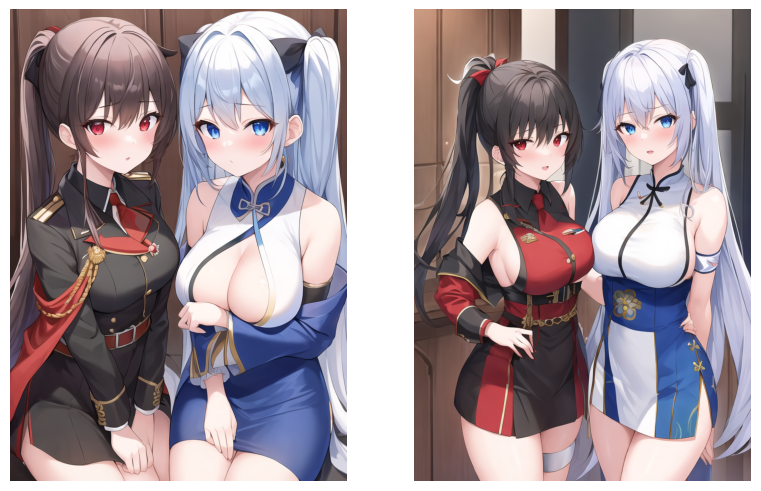

In [29]:
import matplotlib.pyplot as plt
import math
plt.figure(figsize=(20,20))
for i,image in enumerate(images):
    plt.subplot(math.ceil(len(images)/4),4,i+1)
    plt.imshow(np.array(image))
    plt.axis('off')